<a href="https://colab.research.google.com/github/Mushrifah/ICR/blob/master/basic_page_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import math
import numpy as np
import imutils
from IPython.display import Image

In [0]:
def detectOrientation(image):
    # convert the image to grayscale and flip the foreground
    # and background to ensure foreground is now "white" and
    # the background is "black"
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)

    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle
    
    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return (angle, rotated)

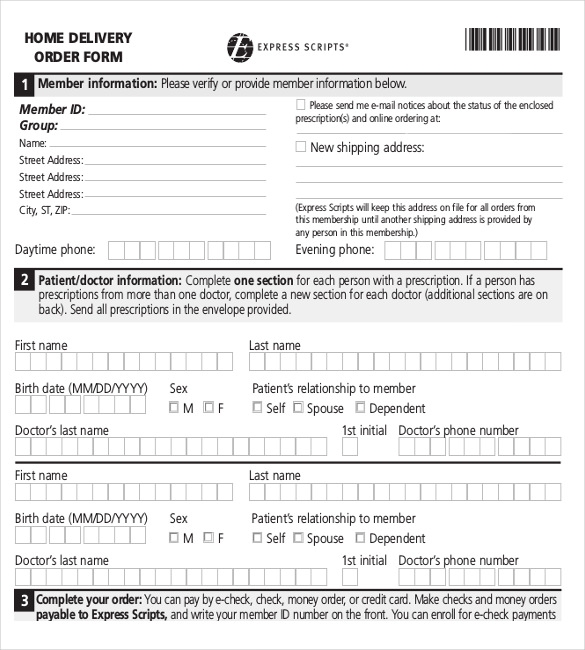

In [3]:
inputPath = 'form2.jpg'
img = cv2.imread(inputPath)
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [4]:
print(img)

[[[200 200 200]
  [226 226 226]
  [221 221 221]
  ...
  [222 222 222]
  [222 222 222]
  [205 205 205]]

 [[227 227 227]
  [255 255 255]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [222 222 222]]

 [[222 222 222]
  [253 253 253]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [222 222 222]]

 ...

 [[222 222 222]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [222 222 222]]

 [[228 228 228]
  [251 251 251]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [222 222 222]]

 [[201 201 201]
  [222 222 222]
  [224 224 224]
  ...
  [223 223 223]
  [223 223 223]
  [205 205 205]]]


In [5]:


# Probabilistic Line Transformation.
#img = cv2.imread(inputPath)
img = imutils.rotate(img, 0)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,200,apertureSize = 3)
minLineLength = 10
maxLineGap = 100
lines = cv2.HoughLinesP(edges,1,np.pi/360,100,minLineLength,maxLineGap)
if lines is not None:
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2,cv2.LINE_AA)

outputPath = inputPath.replace('.jpg', 'output_ProbabilisticLineTransformation.jpg')
cv2.imwrite(outputPath, img)

True

In [6]:
print(detectOrientation(img)[0])

0.0


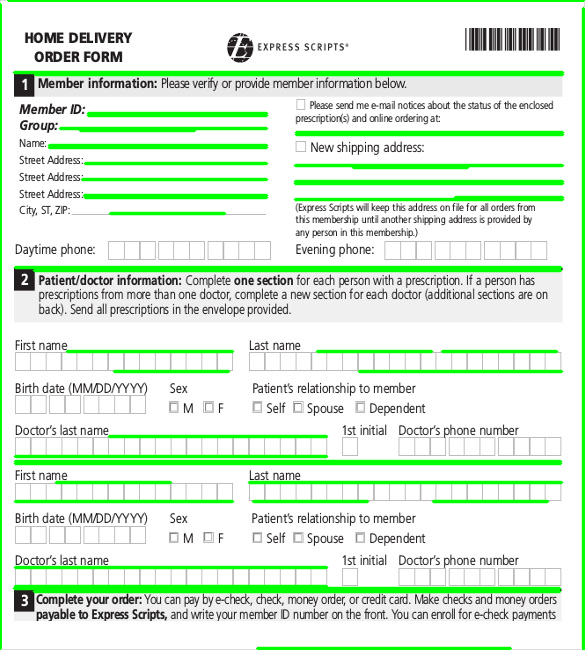

In [7]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

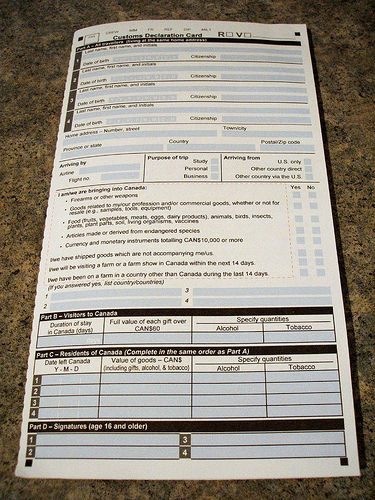

In [8]:
input = 'form8.jpg'
img = cv2.imread(input)
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [9]:
#page detection

import cv2
import numpy as np
import sys

#cv2.cvtColor-The function converts an input image from one color space to another. 

#cv2.COLOR_BGR2RGB-this will convert the image from BGR to RGB format

#so basically the below line of code will convert the image from BGR to RGB
image = cv2.cvtColor(cv2.imread('form8.jpg'), cv2.COLOR_BGR2RGB)

#resize the image to given height
def resize(img, height=800):
    """ Resize image to given height """
    rat = height / img.shape[0]
    return cv2.resize(img, (int(rat * img.shape[1]), height))

# Resize and convert to grayscale
img = cv2.cvtColor(resize(image), cv2.COLOR_BGR2GRAY)

# Bilateral filter preserve edges and reduce noise
#cv2.bilateralFilter(src,diameter of each pixel neighbourhood,sigmaColor,sigmaSpace)
#sigmaColor-filter sigma in color space a larger value will result in larger areas of semi-equal color
#sigmaSpace-filter sigma in coordinate space a larger value will mean that farther pixels will influence each other as long as their colors are close enough

img = cv2.bilateralFilter(img, 9, 75, 75)

# Create black and white image based on adaptive threshold
#transforms grayscale image to binary
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)

# Median filter clears small details
img = cv2.medianBlur(img, 11)

# Add black border in case that page is touching an image border
img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
edges = cv2.Canny(img, 200, 250)

#Contours can be explained simply as a curve joining all the continuous points
#cv2.RETR_TREE- finds all the promising contour lines and reconstructs a full hierarchy of nested contours. 
#cv2.CHAIN_APPROX_SIMPLE- returns only the endpoints that are necessary for drawing the contour line
#so at the end we will get a coordinates (x,y) of corners of image
# Getting contours  
im2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Finding contour of biggest rectangle
# Otherwise return corners of original image
# Don't forget on our 5px border!
height = edges.shape[0]
width = edges.shape[1]
MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

# Page fill at least half of image, then saving max area found
maxAreaFound = MAX_COUNTOUR_AREA * 0.5

# Saving page contour
pageContour = np.array([[5, 5], [5, height-5], [width-5, height-5], [width-5, 5]])

# Go through all contours
for cnt in contours:
    # Simplify contour
    perimeter = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

    # Page has 4 corners and it is convex
    # Page area must be bigger than maxAreaFound 
    if (len(approx) == 4 and
            cv2.isContourConvex(approx) and
            maxAreaFound < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):

        maxAreaFound = cv2.contourArea(approx)
        pageContour = approx

# Result in pageConoutr (numpy array of 4 points):


def fourCornersSort(pts):
    """ Sort corners: top-left, bottom-left, bottom-right, top-right """
    # Difference and sum of x and y value
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    
    # Top-left point has smallest sum...
    # np.argmin() returns INDEX of min
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contourOffset(cnt, offset):
    """ Offset contour, by 5px border """
    # Matrix addition
    cnt += offset
    
    # if value < 0 => replace it by 0
    cnt[cnt < 0] = 0
    return cnt


# Sort and offset corners
pageContour = fourCornersSort(pageContour[:, 0])
pageContour = contourOffset(pageContour, (-5, -5))

# Recalculate to original scale - start Points
sPoints = pageContour.dot(image.shape[0] / 800)
  
# Using Euclidean distance
# Calculate maximum height (maximal length of vertical edges) and width
height = max(np.linalg.norm(sPoints[0] - sPoints[1]),
             np.linalg.norm(sPoints[2] - sPoints[3]))
width = max(np.linalg.norm(sPoints[1] - sPoints[2]),
             np.linalg.norm(sPoints[3] - sPoints[0]))

# Create target points
tPoints = np.array([[0, 0],
                    [0, height],
                    [width, height],
                    [width, 0]], np.float32)

# getPerspectiveTransform() needs float32
if sPoints.dtype != np.float32:
    sPoints = sPoints.astype(np.float32)

# Wraping perspective
M = cv2.getPerspectiveTransform(sPoints, tPoints) 
newImage = cv2.warpPerspective(image, M, (int(width), int(height)))

# Saving the result. Yay! (don't forget to convert colors bact to BGR)
cv2.imwrite("result-page-detection.jpg", newImage)

True

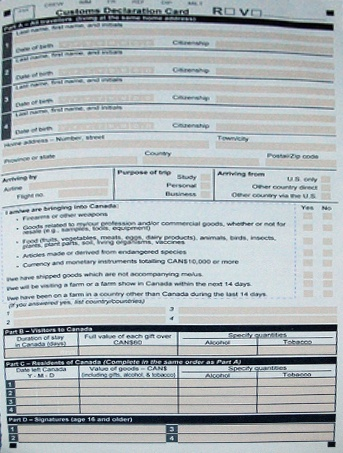

In [10]:

output = 'result-page-detection.jpg'
img = cv2.imread(output)
#from google.colab.patches import cv2_imshow
cv2_imshow(img)